# Modern Powley Framework Demo Notebook

This notebook provides an interactive demonstration of the Modern Powley framework for propellant selection and ballistic calculations. It guides you through the entire process, from data loading and parsing to analysis, visualization, and propellant selection.

## What is the Modern Powley Framework?

The Modern Powley framework is a tool for reloading enthusiasts and ballisticians to select optimal propellants for specific cartridges. It uses ballistic data from GRT (Gun Response Technology) simulations to calculate key metrics like Ba_eff (effective vivacity), Relative Capacity (RC), and Sectional Density (SD) for intelligent propellant recommendations.

## Prerequisites

- Python 3.x installed
- Required libraries: pandas, numpy, matplotlib (install with `pip install -r requirements.txt`)
- GRT .grtload files in the `data/GRT_Files/` directory

Let's get started!

In [1]:
# Step 1: Import necessary libraries and set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import xml.etree.ElementTree as ET

# Enable inline plotting for Jupyter
%matplotlib inline

# Set the project root directory
project_root = '/home/justin/projects/ModernPowley'
os.chdir(project_root)

# Define data and plots directories
data_dir = os.path.join(project_root, 'data')
plots_dir = os.path.join(project_root, 'plots')
grt_dir = os.path.join(data_dir, 'GRT_Files')

# Ensure plots directory exists
os.makedirs(plots_dir, exist_ok=True)

print(f"Working directory: {os.getcwd()}")
print(f"Data directory: {data_dir}")
print(f"Plots directory: {plots_dir}")
print(f"GRT files directory: {grt_dir}")

# Check if required data files exist
required_files = ['CartridgeData.csv', 'propellant_params.csv']
for file in required_files:
    if os.path.exists(os.path.join(data_dir, file)):
        print(f"✓ {file} found")
    else:
        print(f"✗ {file} not found - will be created from GRT files")

Working directory: /home/justin/projects/ModernPowley
Data directory: /home/justin/projects/ModernPowley/data
Plots directory: /home/justin/projects/ModernPowley/plots
GRT files directory: /home/justin/projects/ModernPowley/data/GRT_Files
✓ CartridgeData.csv found
✓ propellant_params.csv found


## Step 2: Data Loading and Parsing

The first step is to parse the GRT (Gun Response Technology) XML files. These files contain detailed ballistic simulation data for various cartridge loads.

We'll extract:
- Cartridge specifications (dimensions, volumes)
- Bullet information (mass, diameter, length)
- Propellant parameters (Ba, a0, z1, z2, etc.)
- Performance data (muzzle velocity, pressures)

The parsing involves converting units and mapping XML fields to our desired data structure.

In [2]:
# Step 2a: Parse cartridge data from GRT files
# Unit conversion constants
CM3_TO_GR_H2O = 15.432
MM_TO_INCH = 1 / 25.4
G_TO_GR = 1 / 0.0648

# Mapping of GRT fields to desired columns
CARTRIDGE_MAPPING = {
    'casevol': 'case_vol',
    'Aeff': 'eff_case_vol',
    'Dz': 'groove_dia',
    'oal': 'oal',
    'caselen': 'case_length',
    'xe': 'barrel_length',
    'mp': 'bullet_mass',
    'Dbul': 'bullet_dia',
    'glen': 'bullet_length',
    'mc': 'propellant_mass',
}

# Fields that need unit conversion
UNIT_CONVERSIONS = {
    'case_vol': CM3_TO_GR_H2O,
    'groove_dia': MM_TO_INCH,
    'oal': MM_TO_INCH,
    'case_length': MM_TO_INCH,
    'barrel_length': MM_TO_INCH,
    'bullet_mass': G_TO_GR,
    'bullet_dia': MM_TO_INCH,
    'bullet_length': MM_TO_INCH,
    'propellant_mass': G_TO_GR,
}

def parse_grt_cartridge(file_path):
    """Parse a single GRT XML file and extract cartridge data."""
    tree = ET.parse(file_path)
    root = tree.getroot()

    data = {}

    # Extract cartridge name
    title = root.find('.//title')
    if title is not None and title.text:
        data['cartridge_name'] = title.text.replace('%20', ' ').replace('%2C', ',')
    else:
        caliber_name = root.find('.//caliber/input[@name="CaliberName"]')
        if caliber_name is not None:
            data['cartridge_name'] = caliber_name.get('value', '').replace('%20', ' ')

    # Parse inputs
    for section in ['caliber', 'gun', 'projectile', 'propellant']:
        section_elem = root.find(f'.//{section}')
        if section_elem is not None:
            for inp in section_elem:
                name = inp.get('name')
                value = inp.get('value')
                if name in CARTRIDGE_MAPPING and value:
                    try:
                        data[CARTRIDGE_MAPPING[name]] = float(value)
                    except ValueError:
                        data[CARTRIDGE_MAPPING[name]] = value

    # Apply unit conversions
    for field, factor in UNIT_CONVERSIONS.items():
        if field in data:
            data[field] *= factor

    return data

# Parse all GRT files
grt_files = glob.glob(os.path.join(grt_dir, '*.grtload'))
cartridge_data = []

for file in grt_files:
    data = parse_grt_cartridge(file)
    if data:
        cartridge_data.append(data)

# Create DataFrame and save
cartridge_df = pd.DataFrame(cartridge_data)
cartridge_csv_path = os.path.join(data_dir, 'cartridge_data_from_grt.csv')
cartridge_df.to_csv(cartridge_csv_path, index=False)

print(f"Parsed {len(cartridge_data)} cartridge loads from {len(grt_files)} GRT files")
print(f"Data saved to {cartridge_csv_path}")
print("\nSample cartridge data:")
print(cartridge_df.head())

Parsed 1 cartridge loads from 1 GRT files
Data saved to /home/justin/projects/ModernPowley/data/cartridge_data_from_grt.csv

Sample cartridge data:
                                      cartridge_name   oal  case_length  \
0  6.5 Creedmoor Hornady, ELD-M 26331, 0.264, 140...  2.85         1.91   

    case_vol  groove_dia  eff_case_vol  barrel_length  bullet_dia  \
0  52.554364       0.264     34.645092           18.0    0.264173   

   bullet_mass  bullet_length  propellant_mass  
0   139.997645        1.38189        41.999294  


In [3]:
# Step 2b: Parse propellant parameters from GRT files
# Mapping of GRT var names to desired columns
PARAM_MAPPING = {
    'f': 'Ba',  # Vivacity
    'c_b_': 'a0',  # Ba(phi) coefficient 0
    'c_Z': 'z1',  # Lower burn-up limit
    'c_F': 'z2',  # Upper burn-up limit
    'c_Q': 'bulk_density',  # Bulk density
    'c_u_': 'Qex',  # Energy
    'c_alpha': 'k',  # Adiabatic index
    'c_L3': 'case_length',
    'c_Pmax': 'p_max',
    'Dz': 'groove_dia',
    'Aeff': 'eff_area',
    'casevol': 'case_vol',
}

def parse_grt_prop(file_path):
    """Parse propellant parameters from a GRT file."""
    tree = ET.parse(file_path)
    root = tree.getroot()

    data = {}

    # Parse caliber inputs
    caliber = root.find('.//caliber')
    if caliber is not None:
        for inp in caliber:
            name = inp.get('name')
            value = inp.get('value')
            if name and value:
                try:
                    data[name] = float(value)
                except ValueError:
                    data[name] = value

    # Parse caliberfile vars
    caliberfile = root.find('.//caliberfile')
    if caliberfile is not None:
        for var in caliberfile:
            name = var.get('name')
            value = var.get('value')
            if name in PARAM_MAPPING and value:
                try:
                    data[PARAM_MAPPING[name]] = float(value)
                except ValueError:
                    data[PARAM_MAPPING[name]] = value

    # Parse propellant inputs
    propellant = root.find('.//propellant')
    if propellant is not None:
        for inp in propellant:
            name = inp.get('name')
            value = inp.get('value')
            if name and value:
                try:
                    data[name] = float(value)
                except ValueError:
                    data[name] = value
        
        # Combined propellant name
        manu = data.get('mname')
        pname = data.get('pname')
        if manu and pname:
            data['propellant'] = f"{manu} {pname}"

    return data

# Parse propellant data
propellant_data = []
for file in grt_files:
    data = parse_grt_prop(file)
    if data:
        propellant_data.append(data)

# Create DataFrame and save
propellant_df = pd.DataFrame(propellant_data)
propellant_csv_path = os.path.join(data_dir, 'propellant_params.csv')
propellant_df.to_csv(propellant_csv_path, index=False)

print(f"Parsed propellant parameters from {len(propellant_data)} files")
print(f"Data saved to {propellant_csv_path}")
print("\nSample propellant data:")
print(propellant_df[['propellant', 'Ba', 'a0', 'z1', 'z2']].head())

Parsed propellant parameters from 1 files
Data saved to /home/justin/projects/ModernPowley/data/propellant_params.csv

Sample propellant data:
             propellant        Ba      a0      z1      z2
0  Alliant Reloder%2016  0.468557  1.7895  0.4777  0.8033


## Step 3: Calculations

Now we'll perform the core calculations that power the Modern Powley framework:

1. **Derived Metrics**: Calculate efficiency proxy, mass ratio, etc.
2. **Charge Predictions**: Predict optimal charge weights using empirical formulas
3. **Ba_eff Calculation**: Compute effective vivacity for propellant ranking

In [4]:
# Step 3a: Calculate derived metrics
# For this demo, we'll assume we have a CartridgeData.csv with the necessary columns
# In a real scenario, this would be generated from GRT or other sources
cartridge_full_path = os.path.join(data_dir, 'CartridgeData.csv')
if os.path.exists(cartridge_full_path):
    df = pd.read_csv(cartridge_full_path)
    print("Using existing CartridgeData.csv")
else:
    print("CartridgeData.csv not found. Using parsed data as fallback.")
    df = cartridge_df.copy()
    # Rename columns to match expected format
    df.rename(columns={'cartridge_name': 'cartridge', 'bullet_mass': 'bullet_mass', 'propellant_mass': 'propellant_mass'}, inplace=True)

# Calculate metrics
if 'muzzle_vel' in df.columns and 'est_pmax' in df.columns:
    df['efficiency_proxy'] = df['muzzle_vel'] / df['est_pmax']
if 'propellant_mass' in df.columns and 'bullet_mass' in df.columns:
    df['mass_ratio'] = df['propellant_mass'] / df['bullet_mass']

# Save derived metrics
metrics_path = os.path.join(data_dir, 'derived_metrics.csv')
df.to_csv(metrics_path, index=False)

print("Derived metrics calculated:")
print(df[['cartridge', 'efficiency_proxy', 'mass_ratio']].head())
print(f"\nFull data with metrics saved to {metrics_path}")

Using existing CartridgeData.csv
Derived metrics calculated:
         cartridge  efficiency_proxy  mass_ratio
0    .25 Creedmoor          0.049864    0.311111
1   .223 Remington          0.047177    0.292208
2           6mm GT          0.051928    0.339450
3    .300 Blackout          0.048151    0.136000
4  .308 Winchester          0.042639    0.240000

Full data with metrics saved to /home/justin/projects/ModernPowley/data/derived_metrics.csv


In [5]:
# Step 3b: Compute charge predictions
# Formula: charge_mass ≈ 0.71 * (eff_case_vol)^1.02 * (eff_barrel_length)^0.06
if 'eff_case_vol' in df.columns and 'eff_barrel_length' in df.columns:
    df['Predicted Charge (gr)'] = 0.71 * (df['eff_case_vol'] ** 1.02) * (df['eff_barrel_length'] ** 0.06)
    
    # Prepare output DataFrame
    pred_df = df[['cartridge', 'eff_case_vol', 'eff_barrel_length', 'Predicted Charge (gr)', 'propellant_mass']].copy()
    pred_df.rename(columns={
        'eff_case_vol': 'Eff Case Vol (gr H2O)',
        'eff_barrel_length': 'Eff Barrel Length (in)',
        'propellant_mass': 'Actual Charge (gr)'
    }, inplace=True)
    pred_df['Difference (gr)'] = pred_df['Actual Charge (gr)'] - pred_df['Predicted Charge (gr)']
    
    # Save predictions
    predictions_path = os.path.join(data_dir, 'Predictions.csv')
    pred_df.to_csv(predictions_path, index=False)
    
    print("Charge predictions computed:")
    print(pred_df.head())
    print(f"\nPredictions saved to {predictions_path}")
else:
    print("Required columns for charge prediction not found. Skipping.")

Charge predictions computed:
         cartridge  Eff Case Vol (gr H2O)  Eff Barrel Length (in)  \
0    .25 Creedmoor                  45.28                   21.20   
1   .223 Remington                  25.77                   17.70   
2           6mm GT                  40.61                   25.41   
3    .300 Blackout                  20.76                   13.90   
4  .308 Winchester                  48.40                   17.20   

   Predicted Charge (gr)  Actual Charge (gr)  Difference (gr)  
0              41.673795                42.0         0.326205  
1              23.199224                22.5        -0.699224  
2              37.701990                37.0        -0.701990  
3              18.340498                17.0        -1.340498  
4              44.048622                42.0        -2.048622  

Predictions saved to /home/justin/projects/ModernPowley/data/Predictions.csv


In [6]:
# Step 3c: Compute Ba_eff (effective vivacity)
# Formula: Ba_eff = Ba * (a0 + (1 - a0) * (z2 / 2))
prop_csv_path = os.path.join(data_dir, 'propellant_params.csv')
if os.path.exists(prop_csv_path):
    prop_df = pd.read_csv(prop_csv_path)
    
    if 'Ba' in prop_df.columns and 'a0' in prop_df.columns and 'z2' in prop_df.columns:
        prop_df['Ba_eff'] = prop_df['Ba'] * (prop_df['a0'] + (1 - prop_df['a0']) * (prop_df['z2'] / 2))
        prop_df.to_csv(prop_csv_path, index=False)
        
        print("Ba_eff calculated for propellants:")
        print(prop_df[['propellant', 'Ba', 'a0', 'z2', 'Ba_eff']].head())
        print(f"\nUpdated propellant data saved to {prop_csv_path}")
    else:
        print("Required columns for Ba_eff calculation not found.")
else:
    print("Propellant parameters file not found.")

Ba_eff calculated for propellants:
             propellant        Ba      a0      z2    Ba_eff
0  Alliant Reloder%2016  0.468557  1.7895  0.8033  0.689902

Updated propellant data saved to /home/justin/projects/ModernPowley/data/propellant_params.csv


## Step 4: Data Analysis

Let's perform some statistical analysis on our data to gain insights into the ballistic performance and validate our predictions.

In [7]:
# Step 4: Perform statistical analysis
print("=== Statistical Insights ===")
print("\nCartridge data summary:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
print(df[numerical_cols].describe())

if os.path.exists(os.path.join(data_dir, 'Predictions.csv')):
    pred_analysis_df = pd.read_csv(os.path.join(data_dir, 'Predictions.csv'))
    print("\nPredictions summary:")
    print(pred_analysis_df.describe())
    
    print("\n=== Validation of Predictions ===")
    mae = np.mean(np.abs(pred_analysis_df['Difference (gr)']))
    rmse = np.sqrt(np.mean(pred_analysis_df['Difference (gr)']**2))
    print(f"Mean Absolute Error (MAE): {mae:.2f} gr")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f} gr")
    print(f"Average Difference: {pred_analysis_df['Difference (gr)'].mean():.2f} gr")

if 'muzzle_vel' in df.columns and 'barrel_length' in df.columns:
    print("\n=== Trends and Anomalies ===")
    corr = df['muzzle_vel'].corr(df['barrel_length'])
    print(f"Correlation between muzzle velocity and barrel length: {corr:.2f}")
    
    # Check for outliers in muzzle velocity
    q1 = df['muzzle_vel'].quantile(0.25)
    q3 = df['muzzle_vel'].quantile(0.75)
    iqr = q3 - q1
    outliers = df[(df['muzzle_vel'] < q1 - 1.5*iqr) | (df['muzzle_vel'] > q3 + 1.5*iqr)]
    print(f"Outliers in muzzle velocity: {len(outliers)} found")
    if not outliers.empty:
        print("Outlier cartridges:")
        print(outliers[['cartridge', 'muzzle_vel']])

=== Statistical Insights ===

Cartridge data summary:
             id  groove_dia    case_vol  case_length  cartridge_oal  \
count  10.00000     10.0000   10.000000    10.000000      10.000000   
mean    5.50000      0.2683   51.993000     1.882400       2.732500   
std     3.02765      0.0301   21.525198     0.285619       0.391104   
min     1.00000      0.2240   24.400000     1.356000       2.100000   
25%     3.25000      0.2465   44.875000     1.748250       2.575000   
50%     5.50000      0.2640   52.200000     1.915000       2.800000   
75%     7.75000      0.2970   55.232500     1.983750       2.843750   
max    10.00000      0.3080  105.100000     2.483000       3.550000   

       barrel_length  eff_case_vol  bullet_mass  bullet_length  bulk_density  \
count      10.000000     10.000000    10.000000      10.000000     10.000000   
mean       23.800000     45.720000   139.950000       1.315500    901.800000   
std         5.202563     20.006616    41.247525       0.199168    

## Step 5: Data Visualization

Visualization is key to understanding ballistic data. Let's create several plots to illustrate the relationships between different parameters.

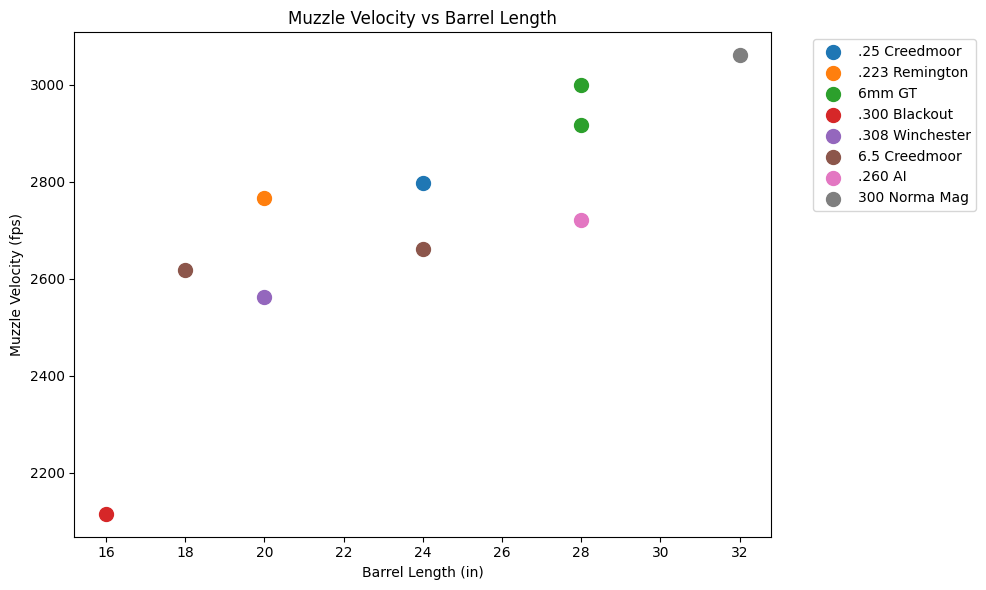

Velocity vs barrel length plot saved to /home/justin/projects/ModernPowley/plots/velocity_vs_barrel.png


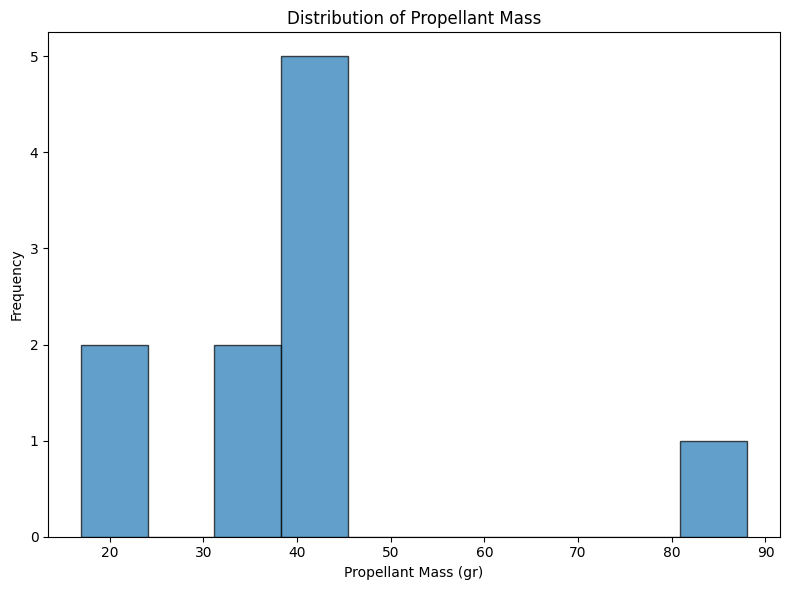

Propellant mass histogram saved to /home/justin/projects/ModernPowley/plots/propellant_mass_hist.png


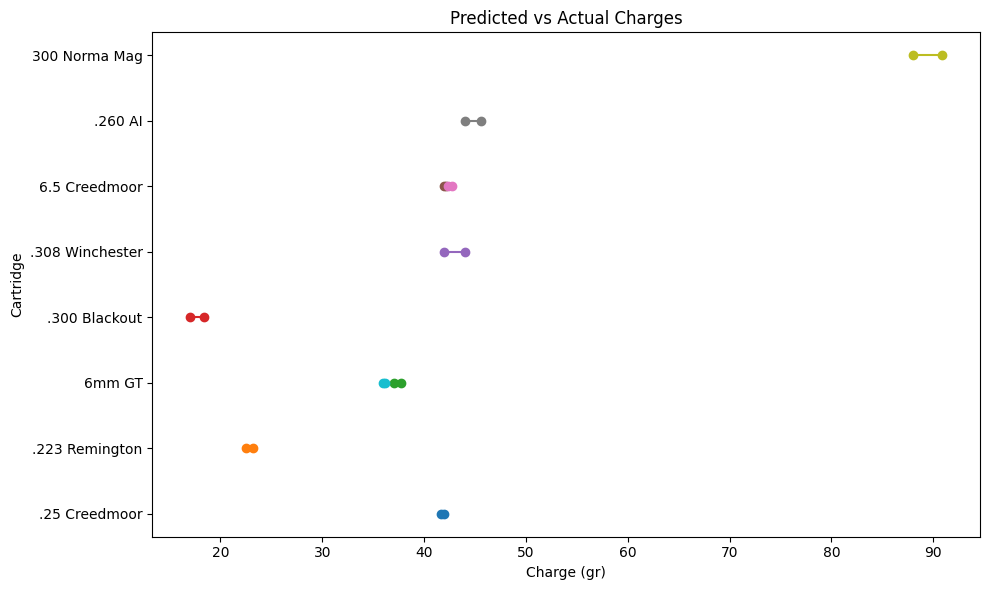

Predicted vs actual charges plot saved to /home/justin/projects/ModernPowley/plots/predicted_vs_actual.png


In [8]:
# Step 5a: Generate plots
# Set style
plt.style.use('default')

# Plot 1: Muzzle velocity vs barrel length
if 'muzzle_vel' in df.columns and 'barrel_length' in df.columns:
    plt.figure(figsize=(10, 6))
    for cart in df['cartridge'].unique():
        sub = df[df['cartridge'] == cart]
        plt.scatter(sub['barrel_length'], sub['muzzle_vel'], label=cart, s=100)
    plt.title('Muzzle Velocity vs Barrel Length')
    plt.xlabel('Barrel Length (in)')
    plt.ylabel('Muzzle Velocity (fps)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    velocity_plot_path = os.path.join(plots_dir, 'velocity_vs_barrel.png')
    plt.savefig(velocity_plot_path)
    plt.show()
    print(f"Velocity vs barrel length plot saved to {velocity_plot_path}")
else:
    print("Required columns for velocity plot not found.")

# Plot 2: Propellant mass distribution
if 'propellant_mass' in df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df['propellant_mass'], bins=10, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Propellant Mass')
    plt.xlabel('Propellant Mass (gr)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    mass_hist_path = os.path.join(plots_dir, 'propellant_mass_hist.png')
    plt.savefig(mass_hist_path)
    plt.show()
    print(f"Propellant mass histogram saved to {mass_hist_path}")
else:
    print("Propellant mass column not found for histogram.")

# Plot 3: Predicted vs Actual charges
if os.path.exists(os.path.join(data_dir, 'Predictions.csv')):
    pred_plot_df = pd.read_csv(os.path.join(data_dir, 'Predictions.csv'))
    plt.figure(figsize=(10, 6))
    for _, row in pred_plot_df.iterrows():
        plt.plot([row['Predicted Charge (gr)'], row['Actual Charge (gr)']], 
                 [row['cartridge'], row['cartridge']], marker='o')
    plt.title('Predicted vs Actual Charges')
    plt.xlabel('Charge (gr)')
    plt.ylabel('Cartridge')
    plt.tight_layout()
    pred_vs_actual_path = os.path.join(plots_dir, 'predicted_vs_actual.png')
    plt.savefig(pred_vs_actual_path)
    plt.show()
    print(f"Predicted vs actual charges plot saved to {pred_vs_actual_path}")
else:
    print("Predictions file not found for comparison plot.")

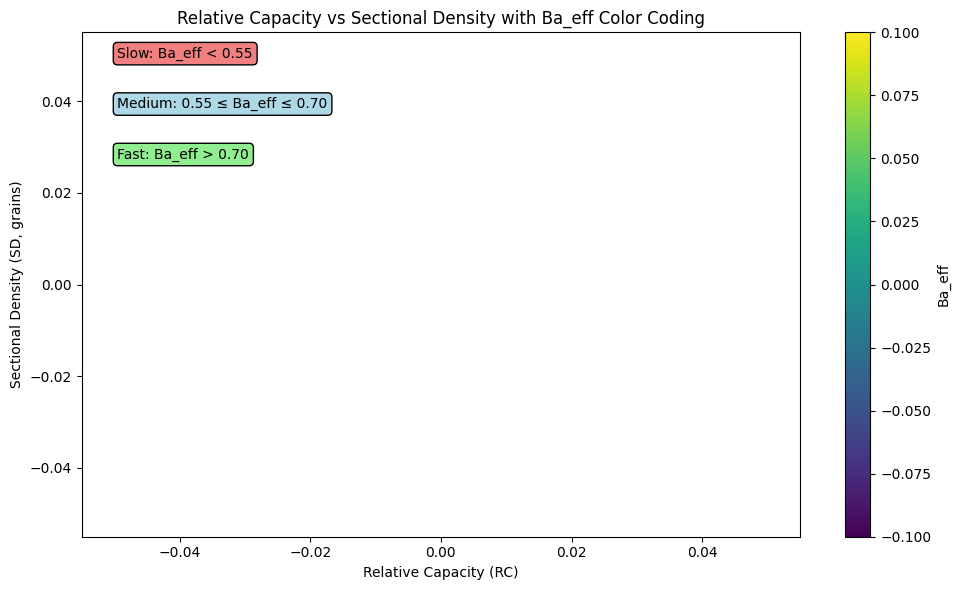

RC vs SD plot saved to /home/justin/projects/ModernPowley/plots/rc_sd_ba_eff.png


In [9]:
# Step 5b: RC vs SD plot with Ba_eff coloring
# Calculate RC and SD if possible
if 'eff_case_vol' in df.columns and 'groove_dia' in df.columns and 'bullet_mass' in df.columns:
    df['bore_area'] = np.pi * (df['groove_dia']/2)**2
    df['bore_cap_per_inch'] = df['bore_area'] * 252.3  # gr H2O/inch
    df['RC'] = df['eff_case_vol'] / df['bore_cap_per_inch']
    df['SD'] = df['bullet_mass']  # approximate
    
    # Add Ba_eff if propellant data available
    if os.path.exists(prop_csv_path):
        prop_df = pd.read_csv(prop_csv_path)
        if 'Ba_eff' in prop_df.columns and 'propellant_name' in df.columns:
            ba_eff_dict = dict(zip(prop_df['pname'], prop_df['Ba_eff']))
            df['Ba_eff'] = df['propellant_name'].map(ba_eff_dict)
            
            # Create the plot
            plt.figure(figsize=(10, 6))
            scatter = plt.scatter(df['RC'], df['SD'], c=df['Ba_eff'], cmap='viridis', s=100, edgecolor='k')
            plt.colorbar(scatter, label='Ba_eff')
            plt.title('Relative Capacity vs Sectional Density with Ba_eff Color Coding')
            plt.xlabel('Relative Capacity (RC)')
            plt.ylabel('Sectional Density (SD, grains)')
            
            # Add band annotations
            plt.text(0.05, 0.95, 'Slow: Ba_eff < 0.55', transform=plt.gca().transAxes, 
                     fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            plt.text(0.05, 0.85, 'Medium: 0.55 ≤ Ba_eff ≤ 0.70', transform=plt.gca().transAxes, 
                     fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
            plt.text(0.05, 0.75, 'Fast: Ba_eff > 0.70', transform=plt.gca().transAxes, 
                     fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
            
            plt.tight_layout()
            rc_sd_path = os.path.join(plots_dir, 'rc_sd_ba_eff.png')
            plt.savefig(rc_sd_path)
            plt.show()
            print(f"RC vs SD plot saved to {rc_sd_path}")
        else:
            print("Ba_eff data not available for color coding.")
    else:
        print("Propellant data not found for Ba_eff.")
else:
    print("Required columns for RC/SD calculation not found.")

## Step 6: Propellant Selection Demo

The core feature of the Modern Powley framework is intelligent propellant selection. Let's demonstrate how to select the best propellant for a given cartridge.

The selection process involves:
1. Calculating Relative Capacity (RC) and Sectional Density (SD) for the cartridge
2. Determining the ideal Ba_eff based on RC
3. Ranking propellants by how closely their Ba_eff matches the ideal value

In [10]:
# Step 6: Demonstrate propellant selection
print("=== Propellant Selection Demo ===")

# For demo purposes, let's use example values or pick from existing data
if not df.empty:
    # Use the first cartridge as example
    example_cartridge = df.iloc[0]
    cartridge_name = example_cartridge.get('cartridge', 'Example Cartridge')
    groove_dia = example_cartridge.get('groove_dia', 0.308)  # Default .308
    case_vol = example_cartridge.get('eff_case_vol', 50)  # Default
    barrel_length = example_cartridge.get('eff_barrel_length', 20)  # Default
    bullet_mass = example_cartridge.get('bullet_mass', 168)  # Default 168gr
else:
    # Fallback values
    cartridge_name = '6.5 Creedmoor Example'
    groove_dia = 0.264
    case_vol = 52.0
    barrel_length = 24.0
    bullet_mass = 140.0

print(f"Example cartridge: {cartridge_name}")
print(f"Groove diameter: {groove_dia} in")
print(f"Case volume: {case_vol} gr H2O")
print(f"Barrel length: {barrel_length} in")
print(f"Bullet mass: {bullet_mass} gr")

# Calculate RC and SD
eff_case_vol = case_vol
eff_barrel_length = barrel_length - 2.5  # rough cartridge OAL approx
bore_area = np.pi * (groove_dia/2)**2
bore_cap_per_inch = bore_area * 253
RC = eff_case_vol / bore_cap_per_inch
SD = bullet_mass

# Predict charge
predicted_charge = 0.71 * (eff_case_vol ** 1.02) * (eff_barrel_length ** 0.06)

print(f"\nCalculated metrics:")
print(f"Predicted charge: {predicted_charge:.2f} gr")
print(f"Relative Capacity (RC): {RC:.2f}")
print(f"Sectional Density (SD): {SD}")

# Find closest cartridge in database
if len(df) > 0 and 'eff_case_vol' in df.columns:
    df['RC_calc'] = df['eff_case_vol'] / (np.pi * (df['groove_dia']/2)**2 * 253)
    df['SD_calc'] = df['bullet_mass']
    distances = np.sqrt((df['RC_calc'] - RC)**2 + (df['SD_calc'] - SD)**2)
    closest_idx = distances.idxmin()
    closest_cartridge = df.loc[closest_idx, 'cartridge']
    print(f"Closest cartridge in database: {closest_cartridge}")

# Calculate ideal Ba_eff
ideal_ba_eff = max(0.45, min(0.9, -0.05 * RC + 0.85))
print(f"Ideal Ba_eff: {ideal_ba_eff:.3f}")

# Rank propellants
if os.path.exists(prop_csv_path):
    prop_df = pd.read_csv(prop_csv_path)
    if 'Ba_eff' in prop_df.columns and 'pname' in prop_df.columns:
        prop_df['pname'] = prop_df['pname'].str.replace('%20', ' ')
        propellant_dict = dict(zip(prop_df['pname'], prop_df['Ba_eff']))
        
        # Rank by closeness to ideal
        rankings = sorted(propellant_dict.items(), key=lambda x: abs(x[1] - ideal_ba_eff))
        top_suggestions = [name for name, _ in rankings[:5]]
        
        print(f"\nTop 5 suggested propellants (ranked by Ba_eff closeness to ideal):")
        for i, prop in enumerate(top_suggestions, 1):
            ba_eff_val = propellant_dict.get(prop, 'N/A')
            print(f"{i}. {prop} (Ba_eff: {ba_eff_val})")
    else:
        print("Propellant data not properly formatted for selection.")
else:
    print("Propellant data not found for selection.")

# Create a summary
summary = f"""
Propellant Selection Summary for {cartridge_name}
===========================================
Cartridge specs: Groove dia {groove_dia}", Case vol {case_vol} gr H2O, Barrel {barrel_length}", Bullet {bullet_mass} gr
Calculated: RC={RC:.2f}, SD={SD}, Predicted charge={predicted_charge:.2f} gr
Ideal Ba_eff: {ideal_ba_eff:.3f}
"""
if 'top_suggestions' in locals():
    summary += "Top propellants: " + ", ".join(top_suggestions[:3])

summary_path = os.path.join(data_dir, 'demo_summary.txt')
with open(summary_path, 'w') as f:
    f.write(summary)
    
print(f"\nSummary saved to {summary_path}")
print(summary)

=== Propellant Selection Demo ===
Example cartridge: .25 Creedmoor
Groove diameter: 0.257 in
Case volume: 45.28 gr H2O
Barrel length: 21.2 in
Bullet mass: 135.0 gr

Calculated metrics:
Predicted charge: 41.36 gr
Relative Capacity (RC): 3.45
Sectional Density (SD): 135.0
Closest cartridge in database: .25 Creedmoor
Ideal Ba_eff: 0.677

Top 5 suggested propellants (ranked by Ba_eff closeness to ideal):
1. Reloder 16 (Ba_eff: 0.689902073410025)

Summary saved to /home/justin/projects/ModernPowley/data/demo_summary.txt

Propellant Selection Summary for .25 Creedmoor
Cartridge specs: Groove dia 0.257", Case vol 45.28 gr H2O, Barrel 21.2", Bullet 135.0 gr
Calculated: RC=3.45, SD=135.0, Predicted charge=41.36 gr
Ideal Ba_eff: 0.677
Top propellants: Reloder 16


## Step 7: Create Database (Optional)

For more advanced usage, the framework can create a SQLite database from the CSV data for efficient querying.

In [11]:
# Step 7: Create SQLite database
import sqlite3

db_path = os.path.join(data_dir, 'cartridge_db.sqlite')
csv_path = os.path.join(data_dir, 'CartridgeData.csv')

if os.path.exists(csv_path):
    try:
        # Read CSV
        db_df = pd.read_csv(csv_path)
        db_df.columns = db_df.columns.str.strip()
        
        # Connect to DB and create table
        with sqlite3.connect(db_path) as conn:
            conn.execute('''
            CREATE TABLE IF NOT EXISTS loads (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                cartridge TEXT,
                groove_dia REAL,
                case_vol REAL,
                case_length REAL,
                cartridge_oal REAL,
                barrel_length REAL,
                eff_case_vol REAL,
                bullet_manu TEXT,
                bullet_mass REAL,
                bullet_length REAL,
                propellant_manu TEXT,
                propellant_name TEXT,
                bulk_density REAL,
                propellant_Qex REAL,
                propellant_mass REAL,
                load_ratio REAL,
                eff_barrel_length REAL,
                muzzle_vel REAL,
                est_pmax REAL,
                est_muzzle_pressure REAL
            )
            ''')
            
            # Import data
            db_df.to_sql('loads', conn, if_exists='replace', index=False)
            
        print(f"Database created successfully at {db_path}")
        print(f"Imported {len(db_df)} records")
        
        # Quick query demo
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT cartridge, muzzle_vel FROM loads ORDER BY muzzle_vel DESC LIMIT 5")
            results = cursor.fetchall()
            print("\nTop 5 fastest loads:")
            for row in results:
                print(f"{row[0]}: {row[1]} fps")
                
    except Exception as e:
        print(f"Database creation failed: {e}")
else:
    print("CartridgeData.csv not found. Skipping database creation.")

Database created successfully at /home/justin/projects/ModernPowley/data/cartridge_db.sqlite
Imported 10 records

Top 5 fastest loads:
300 Norma Mag: 3061 fps
6mm GT: 2999 fps
6mm GT: 2918 fps
.25 Creedmoor: 2797 fps
.223 Remington: 2766 fps


## Conclusion

Congratulations! You've completed the Modern Powley framework demo. Here's what we accomplished:

1. **Data Parsing**: Extracted cartridge and propellant data from GRT XML files
2. **Calculations**: Computed derived metrics, charge predictions, and Ba_eff values
3. **Analysis**: Performed statistical analysis and validation of predictions
4. **Visualization**: Created plots showing relationships between ballistic parameters
5. **Propellant Selection**: Demonstrated intelligent propellant recommendation
6. **Database Creation**: Set up SQLite database for advanced querying

### Key Concepts Learned

- **Ba_eff (Effective Vivacity)**: A measure of propellant "speed" that accounts for burn characteristics
- **Relative Capacity (RC)**: Case volume relative to bore capacity
- **Sectional Density (SD)**: Bullet weight relative to caliber
- **Charge Prediction**: Empirical formulas for estimating optimal powder charges

### Next Steps

- Experiment with different cartridges by modifying the propellant selection parameters
- Add your own GRT files to expand the database
- Use the SQLite database for custom queries and analysis
- Integrate with QuickLOAD or other ballistic software

### Resources

- Review the generated plots in the `plots/` directory
- Check the data files in the `data/` directory
- Explore the individual scripts for more advanced usage

The Modern Powley framework helps reloaders make data-driven decisions for optimal propellant selection. Happy shooting!